**Metodologia**

1. Seleção de variáveis: Visando à parcimonicidade do modelo, primeiro realizou-se uma seleção de variáveis com base nos seguintes critérios: (a) variáveis numéricas - coeficiente de variação e correlação de pearson (b) entropia normalizada e informação mútua normalizada. 

2. Amostragem estratificada: Para garantir eficiência computacional, foi extraída uma amostra estratificada do conjunto de dados. A estratificação utilizou a variável CO_MUNICIPIO_PROVA (código do município de aplicação da prova). 

3. Validação interna: A classe KPrototypeEvaluator foi usada para avaliar diferentes hiperparametros do algoritmo k-prototypes (número de clusters e gamma), usando como métricas TWSS, silhouette e índice de Dunn. Silhouette e Dunn foram calculados usando a matriz de distância calculada usando distância de Gower. 

4. Validação externa: Embora não haja true labels para uma validação externa clássica, buscou-se avaliar a capacidade de generalização. Cada algoritmo foi treinado com dados do Amazonas e seus rótulos comparados aos obtidos em um modelo treinado com dados do Rio de Janeiro, utilizando o Adjusted Rand Index (ARI) e inspeção visual.

5. Estabilidade e escalabilidade: A estabilidade foi medida por três experimentos, sempre com ARI:
(a) Seed – impacto da semente aleatória;
(b) Cross-sample – influência da amostra específica utilizada.
A escalabilidade foi avaliada pelo tempo de processamento em diferentes tamanhos de amostra.

6. Importância de variáveis e interpretabilidade: Treinou-se uma árvore de decisão tendo o cluster como variável resposta, a fim de identificar características-chave de cada grupo. Também se analisou a importância das variáveis originais via permutação em random forest e, por fim, a significância das diferenças entre clusters por ANOVA e qui-quadrado, complementada por medidas de efeito (Cohen’s d e Cramer’s V).

In [25]:
import sys
import os
import pandas as pd 

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from scripts.clustering.original_space_clustering import KPrototypesEvaluator, FeatureSelector

In [26]:
df = pd.read_csv(r'C:\Users\jaret\OneDrive\Documents\UFG\TCC\ENEM - final\data\MICRODADOS_RJ_clean_2023.csv')

**Seleção de variáveis**

--- FeatureSelector Initialized ---
Detected 6 numerical columns: ['CO_MUNICIPIO_PROVA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
Detected 29 categorical columns: ['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025']
Performing stratified sampling on 'CO_MUNICIPIO_PROVA' with a 1.00% fraction...
Sampling complete. Active dataset reduced from 177828 to 1776 rows.

--- Starting Feature Analysis ---
Calculating Coefficient of Variation for numerical features...
Calculating Correlation Matrix for numerical features...
Calculating Normalized Entropy for categorical features...
Calculating Normalized Mutual Information for categorical features...


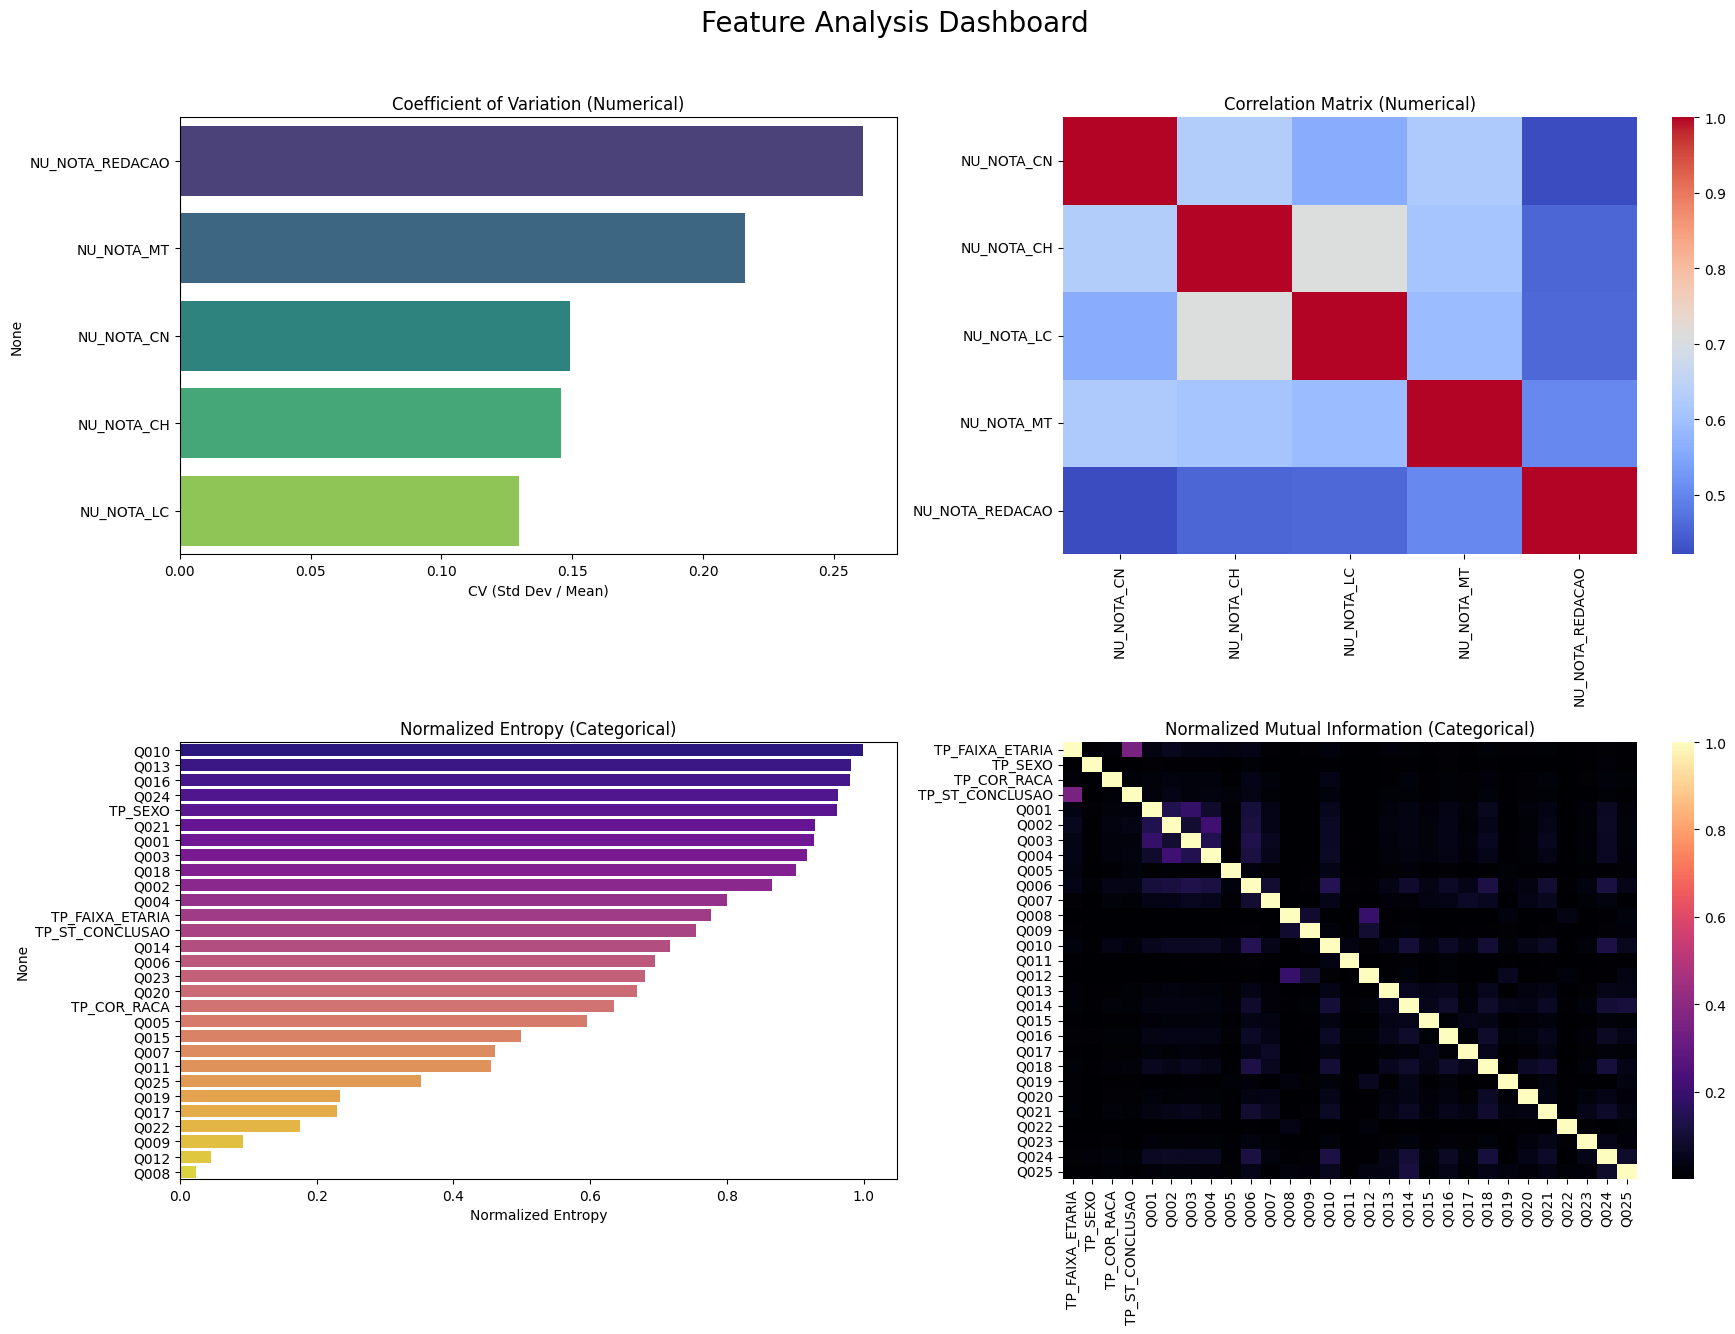

In [27]:
selector = FeatureSelector(df)
selector.stratified_sample(
    strata_col="CO_MUNICIPIO_PROVA", 
    sample_frac=0.01
)
selector.analyze_features()

In [28]:
df_selected = selector.select_features(
    cv_threshold=0.2, 
    correlation_threshold=0.7, 
    entropy_threshold=0.8, 
    mutual_info_threshold=0.5
)
selected_features = df_selected.columns.tolist()
selected_features.append('CO_MUNICIPIO_PROVA')


--- Starting Feature Selection Process ---

Analyzing 5 numerical features...
Checking for Coefficient of Variation below 0.2...
  -> Found 3 low-CV columns to drop: ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC']
Checking for Pearson correlations above 0.7...
  -> No highly correlated column pairs found.

Checking for normalized entropy below 0.8...
  -> Found 18 low-entropy columns to drop: ['TP_FAIXA_ETARIA', 'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q011', 'Q012', 'Q014', 'Q015', 'Q017', 'Q019', 'Q020', 'Q022', 'Q023', 'Q025']
Checking for normalized mutual information above 0.5...
  -> No high mutual information column pairs found.

Dropping a total of 21 unique columns: ['Q008', 'Q011', 'NU_NOTA_CH', 'Q017', 'Q006', 'Q022', 'TP_FAIXA_ETARIA', 'Q023', 'Q020', 'Q019', 'TP_ST_CONCLUSAO', 'Q005', 'Q009', 'Q025', 'TP_COR_RACA', 'Q012', 'Q014', 'NU_NOTA_CN', 'Q015', 'Q007', 'NU_NOTA_LC']
Feature selection complete.

--- Feature Selection Finished ---


**Iniciação da instância da classe do avaliador dos modelos**

In [29]:
k_range = range(2,9)
evaluator = KPrototypesEvaluator(
    df=df[selected_features], 
    original_df_full=df,
    k_range=k_range, 
    gamma_list=[0.1, 0.5, 0.8, 1.0, 2.0, 4.0],
    random_state=42
)
evaluator.stratified_sample(
    strata_col="CO_MUNICIPIO_PROVA", 
    sample_frac=0.01
)
evaluator.scale_numerical_features()

Full original dataframe loaded for statistical analysis.
Detected 3 numerical columns: ['NU_NOTA_MT', 'NU_NOTA_REDACAO', 'CO_MUNICIPIO_PROVA']
Detected 11 categorical columns: ['TP_SEXO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q010', 'Q013', 'Q016', 'Q018', 'Q021', 'Q024']
Performing stratified sampling on 'CO_MUNICIPIO_PROVA' with a 1.00% fraction...
Sampling complete. Active dataset reduced from 177828 to 1776 rows.
Scaling 2 numerical features...
Scaling complete. Active dataset has been updated.


,TP_SEXO,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q010,Q013,Q016,Q018,Q021,Q024
49534,Masculino,1.792239,0.811575,Faculdade ou pós,EM completo,"Grupo 4: técnicos, supervisores, pequenos empr...",Não sabe,Sim,Sim,Sim,Não,Não,Sim
36740,Feminino,-0.530709,0.811575,EM completo,Faculdade ou pós,Grupo 3: operários / técnicos manuais,"Grupo 4: técnicos, supervisores, pequenos empr...",Sim,Sim,Não,Não,Não,Sim
109614,Masculino,1.488379,0.115491,EM completo,EM completo,Grupo 5: profissões de nível superior / gestores,Não sabe,Sim,Sim,Não,Sim,Sim,Sim
40550,Feminino,-1.758601,1.043603,EF incompleto,EF incompleto,Grupo 1: ocupações rurais / básicos,Grupo 1: ocupações rurais / básicos,Não,Não,Não,Não,Não,Não
8599,Feminino,-0.658563,-0.928634,Faculdade ou pós,Faculdade ou pós,Não sabe,"Grupo 4: técnicos, supervisores, pequenos empr...",Não,Não,Não,Não,Não,Sim
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12413,Feminino,0.536950,-1.392690,EM completo,EM completo,"Grupo 2: serviços básicos, comércio","Grupo 2: serviços básicos, comércio",Não,Sim,Sim,Não,Não,Não
109663,Feminino,0.458079,0.231505,EF incompleto,Faculdade ou pós,Grupo 3: operários / técnicos manuais,"Grupo 4: técnicos, supervisores, pequenos empr...",Não,Sim,Sim,Não,Não,Não
155122,Masculino,1.794730,1.043603,Faculdade ou pós,Faculdade ou pós,Grupo 5: profissões de nível superior / gestores,Grupo 5: profissões de nível superior / gestores,Sim,Não,Sim,Não,Não,Sim
120857,Feminino,0.711296,0.347519,EF incompleto,EM completo,Grupo 3: operários / técnicos manuais,"Grupo 4: técnicos, supervisores, pequenos empr...",Sim,Sim,Sim,Sim,Sim,Não



Running K-Prototypes for k in [2, 3, 4, 5, 6, 7, 8] and gamma in [0.1, 0.5, 0.8, 1.0, 2.0, 4.0]...
Calculating Gower distance matrix for evaluation metrics...
Gower matrix calculation complete.
  - Testing k=2, gamma=0.10...
  - Testing k=3, gamma=0.10...
  - Testing k=4, gamma=0.10...
  - Testing k=5, gamma=0.10...
  - Testing k=6, gamma=0.10...
  - Testing k=7, gamma=0.10...
  - Testing k=8, gamma=0.10...
  - Testing k=2, gamma=0.50...
  - Testing k=3, gamma=0.50...
  - Testing k=4, gamma=0.50...
  - Testing k=5, gamma=0.50...
  - Testing k=6, gamma=0.50...
  - Testing k=7, gamma=0.50...
  - Testing k=8, gamma=0.50...
  - Testing k=2, gamma=0.80...
  - Testing k=3, gamma=0.80...
  - Testing k=4, gamma=0.80...
  - Testing k=5, gamma=0.80...
  - Testing k=6, gamma=0.80...
  - Testing k=7, gamma=0.80...
  - Testing k=8, gamma=0.80...
  - Testing k=2, gamma=1.00...
  - Testing k=3, gamma=1.00...
  - Testing k=4, gamma=1.00...
  - Testing k=5, gamma=1.00...
  - Testing k=6, gamma=1.00...

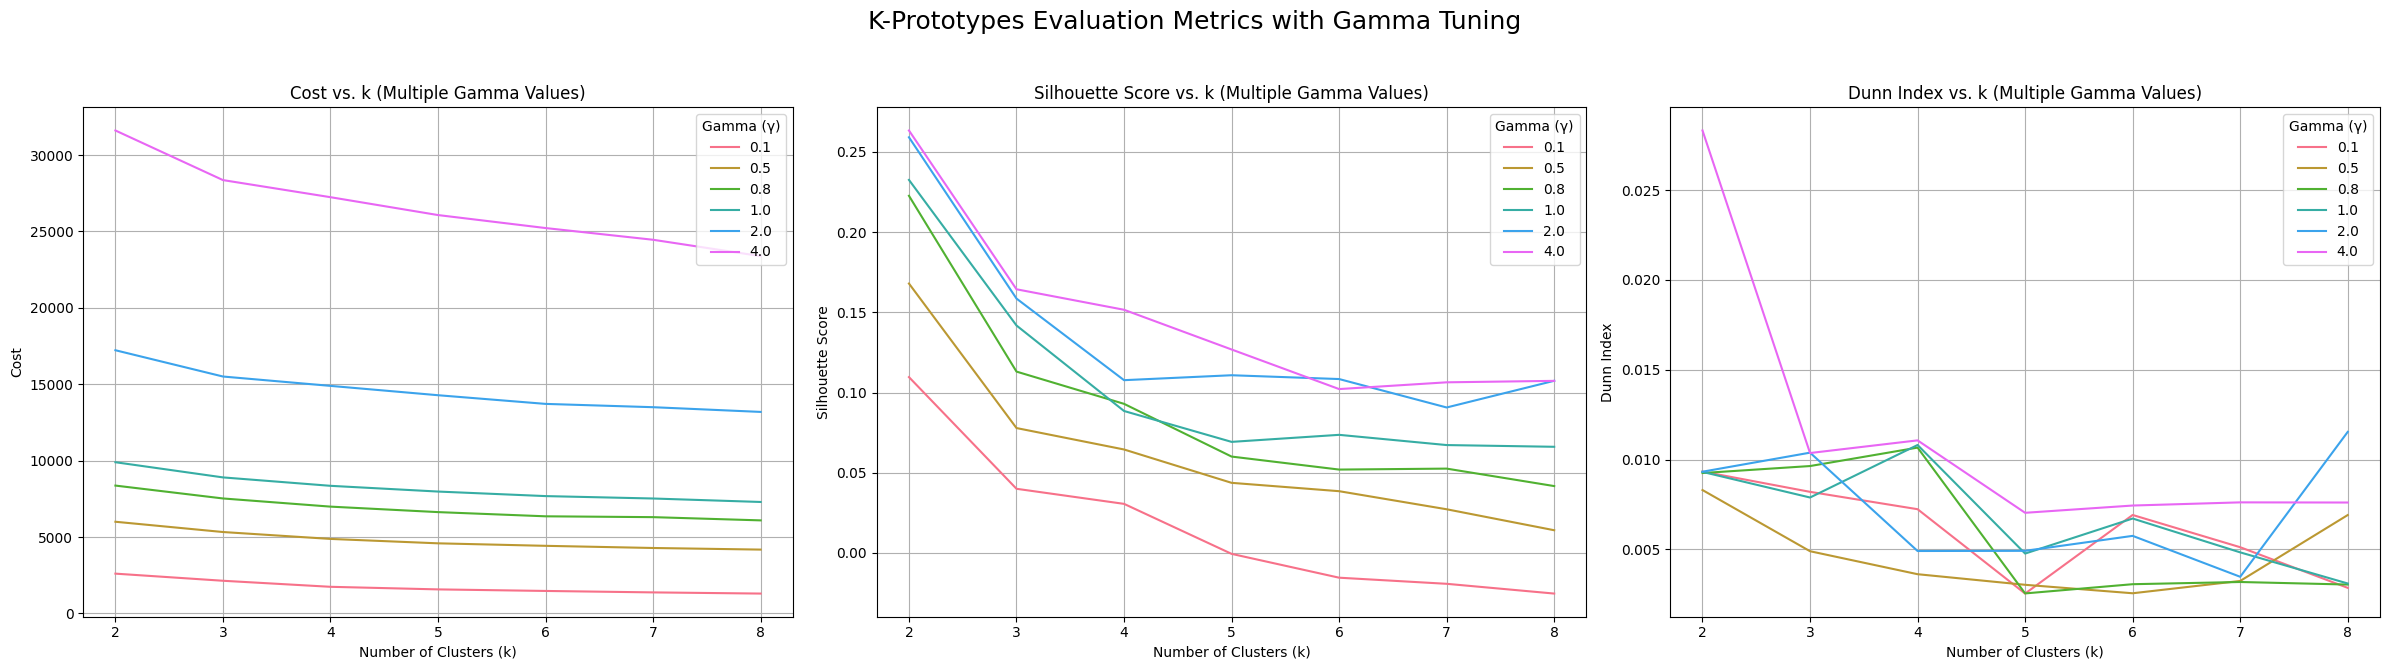

In [30]:
evaluator.run_and_evaluate()
evaluator.plot_evaluation_metrics()

In [31]:
k_prot_model = evaluator.run_final_model(optimal_k=2, optimal_gamma=2)
k_prot_model


Running final K-Prototypes model with k=2, gamma=2...
Final Gamma used: 2
Final model is trained and cluster labels are added to the DataFrame.


,TP_SEXO,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q010,Q013,Q016,Q018,Q021,Q024,cluster_kproto
49534,Masculino,1.792239,0.811575,Faculdade ou pós,EM completo,"Grupo 4: técnicos, supervisores, pequenos empr...",Não sabe,Sim,Sim,Sim,Não,Não,Sim,0
36740,Feminino,-0.530709,0.811575,EM completo,Faculdade ou pós,Grupo 3: operários / técnicos manuais,"Grupo 4: técnicos, supervisores, pequenos empr...",Sim,Sim,Não,Não,Não,Sim,0
109614,Masculino,1.488379,0.115491,EM completo,EM completo,Grupo 5: profissões de nível superior / gestores,Não sabe,Sim,Sim,Não,Sim,Sim,Sim,0
40550,Feminino,-1.758601,1.043603,EF incompleto,EF incompleto,Grupo 1: ocupações rurais / básicos,Grupo 1: ocupações rurais / básicos,Não,Não,Não,Não,Não,Não,1
8599,Feminino,-0.658563,-0.928634,Faculdade ou pós,Faculdade ou pós,Não sabe,"Grupo 4: técnicos, supervisores, pequenos empr...",Não,Não,Não,Não,Não,Sim,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12413,Feminino,0.536950,-1.392690,EM completo,EM completo,"Grupo 2: serviços básicos, comércio","Grupo 2: serviços básicos, comércio",Não,Sim,Sim,Não,Não,Não,1
109663,Feminino,0.458079,0.231505,EF incompleto,Faculdade ou pós,Grupo 3: operários / técnicos manuais,"Grupo 4: técnicos, supervisores, pequenos empr...",Não,Sim,Sim,Não,Não,Não,1
155122,Masculino,1.794730,1.043603,Faculdade ou pós,Faculdade ou pós,Grupo 5: profissões de nível superior / gestores,Grupo 5: profissões de nível superior / gestores,Sim,Não,Sim,Não,Não,Sim,0
120857,Feminino,0.711296,0.347519,EF incompleto,EM completo,Grupo 3: operários / técnicos manuais,"Grupo 4: técnicos, supervisores, pequenos empr...",Sim,Sim,Sim,Sim,Sim,Não,0



--- Generating Cluster Size Plot ---


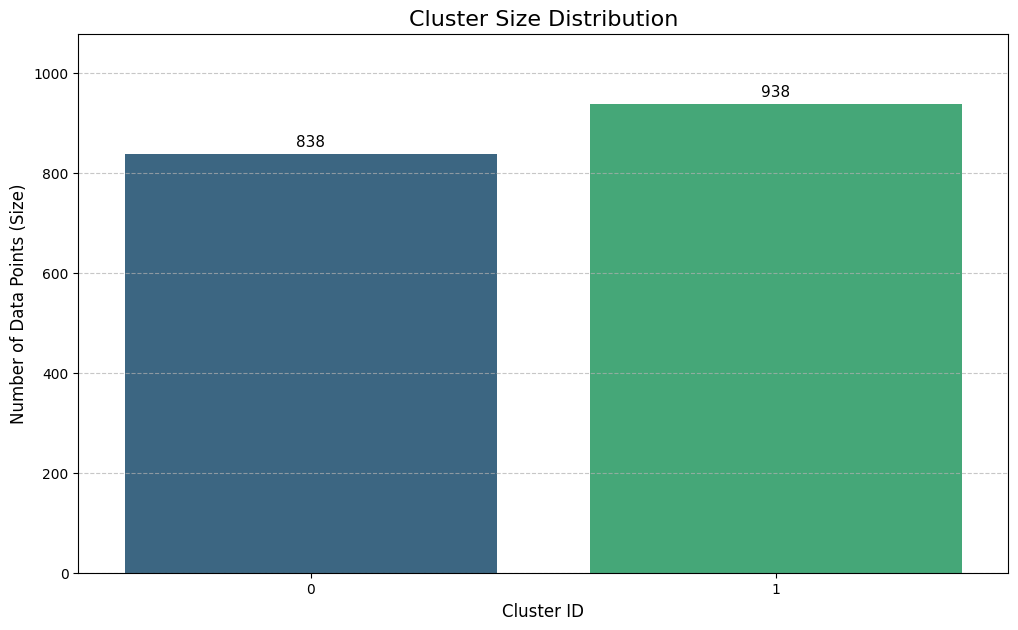

In [32]:
evaluator.plot_cluster_sizes()


--- Generating 2D Cluster Plot using FAMD on all features ---
Using the pre-scaled dataframe for FAMD.
FAMD components generated. Plotting now...


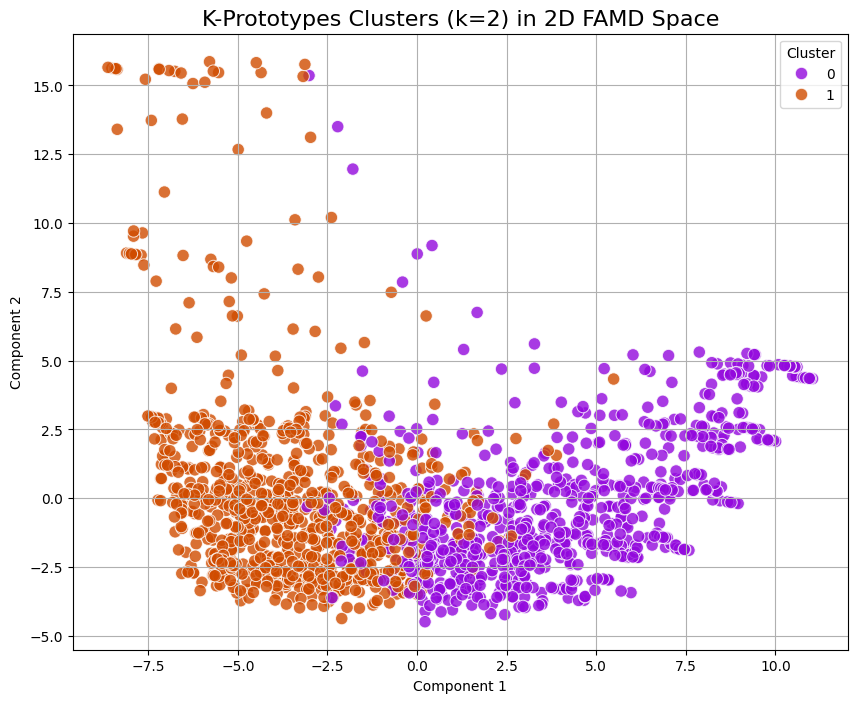

In [33]:
evaluator.plot_clusters_2d()

**Avaliação de validade externa**

In [34]:
df_am = pd.read_csv(r'C:\Users\jaret\OneDrive\Documents\UFG\TCC\ENEM - final\data\MICRODADOS_AM_clean_2023.csv')
df_am = df_am.loc[:, selected_features]

In [35]:
k_range = range(2,9)
evaluator_am = KPrototypesEvaluator(
    df=df_am, 
    k_range=k_range, 
    random_state=42
)
evaluator_am.stratified_sample(
    strata_col="CO_MUNICIPIO_PROVA", 
    sample_frac=0.05
)
evaluator_am.scale_numerical_features()
evaluator_am.run_final_model(optimal_k=2, optimal_gamma=2)

Assuming input dataframe contains all features for statistical analysis.
Detected 3 numerical columns: ['NU_NOTA_MT', 'NU_NOTA_REDACAO', 'CO_MUNICIPIO_PROVA']
Detected 11 categorical columns: ['TP_SEXO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q010', 'Q013', 'Q016', 'Q018', 'Q021', 'Q024']
Performing stratified sampling on 'CO_MUNICIPIO_PROVA' with a 5.00% fraction...
Sampling complete. Active dataset reduced from 44720 to 2237 rows.
Scaling 2 numerical features...
Scaling complete. Active dataset has been updated.

Running final K-Prototypes model with k=2, gamma=2...
Final Gamma used: 2
Final model is trained and cluster labels are added to the DataFrame.


,TP_SEXO,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q010,Q013,Q016,Q018,Q021,Q024,cluster_kproto
27004,Feminino,-1.233048,-0.419925,EF completo,EM completo,Grupo 1: ocupações rurais / básicos,Grupo 1: ocupações rurais / básicos,Não,Não,Não,Não,Não,Não,0
12953,Masculino,-0.181983,1.423429,EF incompleto,EF incompleto,Grupo 1: ocupações rurais / básicos,Grupo 1: ocupações rurais / básicos,Não,Não,Não,Não,Não,Não,0
28689,Feminino,0.276335,0.071636,EF completo,EF completo,Grupo 1: ocupações rurais / básicos,Grupo 1: ocupações rurais / básicos,Não,Não,Não,Não,Não,Não,0
36259,Masculino,0.430612,-0.419925,Faculdade ou pós,EM completo,"Grupo 4: técnicos, supervisores, pequenos empr...","Grupo 4: técnicos, supervisores, pequenos empr...",Não,Sim,Sim,Não,Sim,Sim,1
21852,Feminino,-0.836079,-1.894609,EF incompleto,EF incompleto,Grupo 1: ocupações rurais / básicos,Grupo 1: ocupações rurais / básicos,Não,Não,Não,Não,Sim,Não,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30642,Masculino,0.290771,-1.034377,EM completo,EM completo,Grupo 3: operários / técnicos manuais,"Grupo 2: serviços básicos, comércio",Não,Sim,Não,Não,Não,Não,0
21507,Feminino,-0.041240,-0.788596,EF incompleto,EF incompleto,Grupo 1: ocupações rurais / básicos,"Grupo 2: serviços básicos, comércio",Não,Não,Não,Não,Não,Não,0
43086,Feminino,-0.412947,0.071636,EF completo,Faculdade ou pós,Grupo 1: ocupações rurais / básicos,"Grupo 4: técnicos, supervisores, pequenos empr...",Não,Não,Não,Não,Não,Não,0
8854,Masculino,-0.947952,0.071636,Faculdade ou pós,Faculdade ou pós,"Grupo 4: técnicos, supervisores, pequenos empr...","Grupo 4: técnicos, supervisores, pequenos empr...",Não,Não,Não,Não,Não,Não,0


In [36]:
evaluator.cross_predict_and_evaluate_kproto(
    target_evaluator=evaluator_am, 
    name_source="RJ", 
    name_target="AM"
)


--- Cross-Model Evaluation: 'RJ' Model -> 'AM' Data ---
Predicting labels on 'AM' data using 'RJ' model...
✅ Adjusted Rand Score (ARI): 0.6886


0.6885625407402595


--- Visualizing Cross-Prediction: 'RJ' Model vs. 'AM' Clusters ---
Using the target's pre-scaled data for FAMD visualization.
Reducing target data to 2D using FAMD...


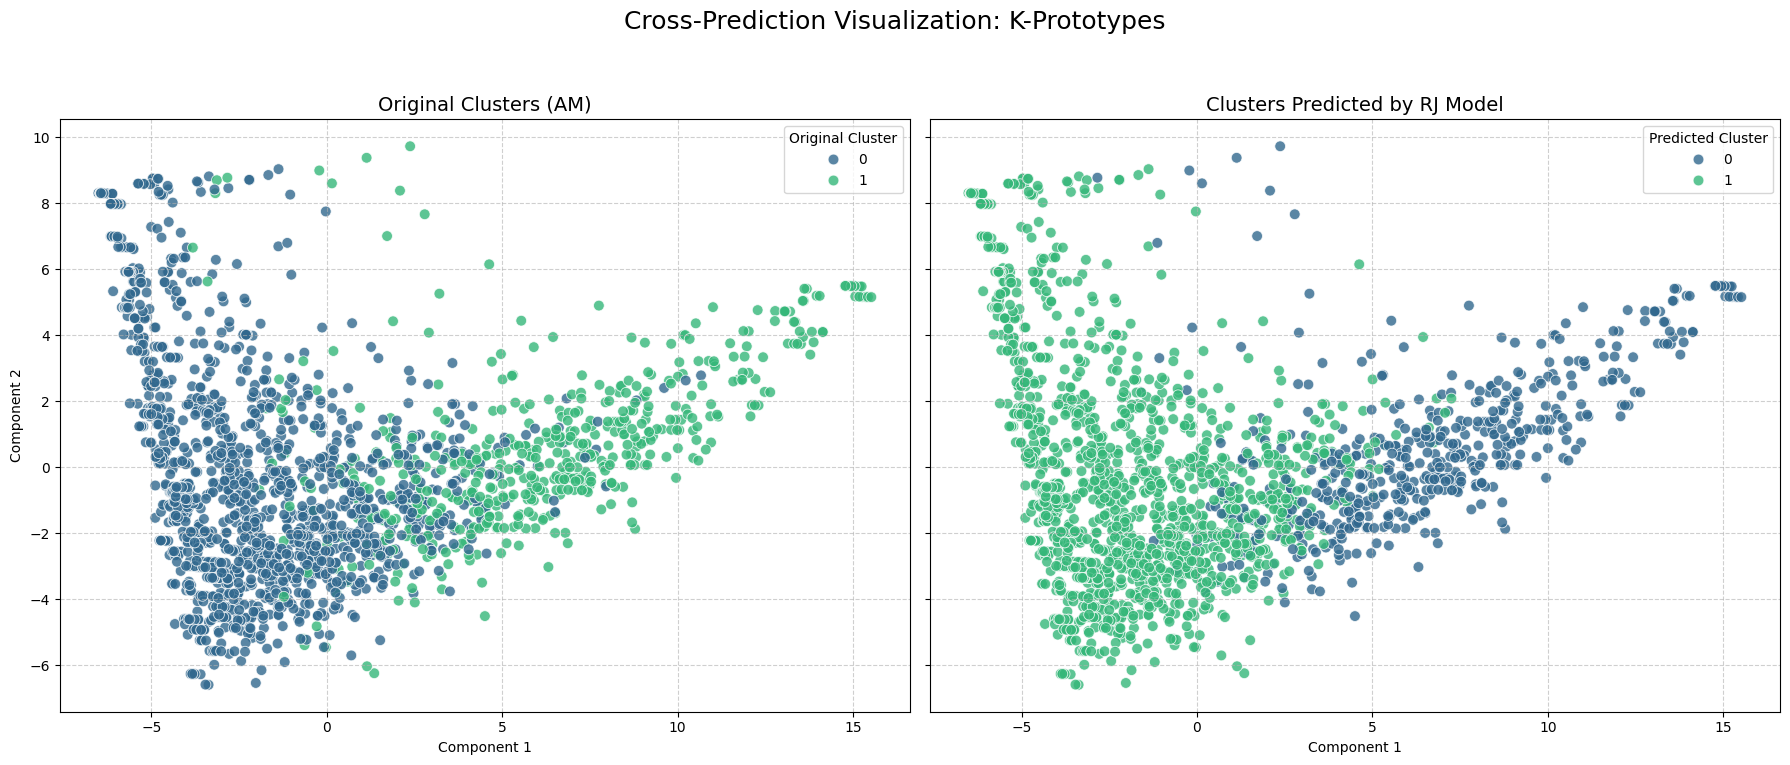

In [37]:
evaluator.plot_cross_prediction_comparison(
    target_evaluator=evaluator_am, 
    name_source="RJ", 
    name_target="AM"
)

**Avaliação de estabilidade e escalabilidade**


--- Evaluating Cross-Sample Stability (50 iterations) ---
Calculating baseline clustering on the current active sample...
Using existing final model as baseline.
Beginning 50 cross-sample validation iterations...
  Iteration 10/50...
  Iteration 20/50...
  Iteration 30/50...
  Iteration 40/50...
  Iteration 50/50...

Cross-sample stability evaluation complete.
K-Prototypes (k=2) Stability: Mean ARI = 0.8041, Std Dev = 0.0812


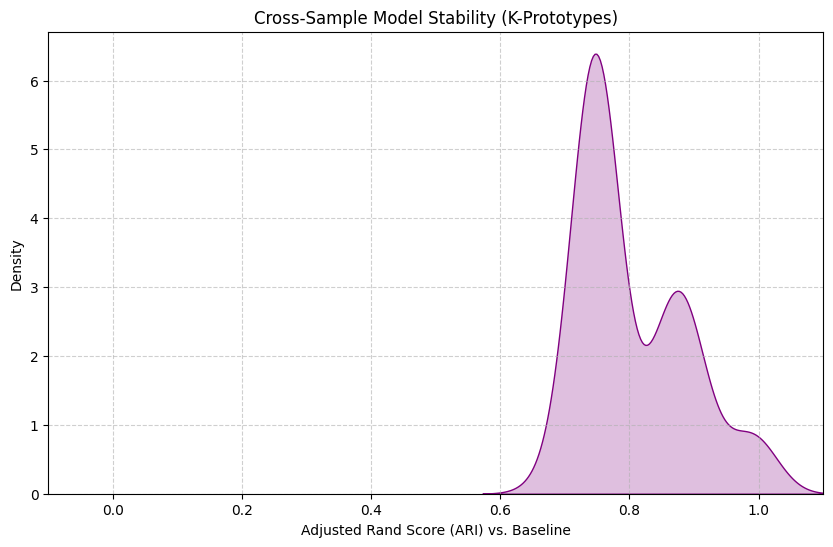

[1.0,
 0.7420035605060634,
 0.7458907844162853,
 0.9954979995643303,
 0.7517437920955856,
 0.753700022421455,
 0.7556567957165247,
 0.7497900450540135,
 0.6849000433328886,
 0.8883704233239246,
 0.7497914365704765,
 0.7400603160307354,
 0.7536986787352566,
 0.747839528287273,
 0.8526250876472472,
 0.7400623984449262,
 0.8567925759855005,
 0.888370112924036,
 0.7536990244423298,
 0.7497914365704765,
 0.7517430951922306,
 0.7458911680028899,
 0.7517444626970068,
 0.7556571354395022,
 0.743945711603472,
 0.7400639404425285,
 0.8904940854797272,
 0.890493853480235,
 0.8609697764095279,
 0.8968868483835856,
 0.7400631832138492,
 0.88624569531798,
 0.9775914764967035,
 0.8609693621998,
 0.7517444626970068,
 0.7478387803528552,
 0.743945711603472,
 0.8968868483835856,
 0.7536993636256848,
 0.8567919995268966,
 0.7497904028740108,
 0.7517441306840109,
 0.743945711603472,
 0.7381237163187768,
 0.7478387803528552,
 0.7381245416202391,
 0.8820091707445267,
 0.8630619833969253,
 0.8609693621998,
 

In [38]:
evaluator.evaluate_cross_sample_stability(
    strata_col="CO_MUNICIPIO_PROVA", 
    sample_frac=0.01, 
    optimal_k=2, 
    optimal_gamma=2)

In [39]:
seeds = [0, 51, 123, 2025, 9999]
evaluator.evaluate_stability_by_seed(
    optimal_k=2, 
    optimal_gamma=2, 
    random_seeds=seeds
)


--- Evaluating Stability by Seed for k=2 ---
K-Prototypes (k=2) Mean ARI vs. baseline seed: 1.0000 (Indicates sensitivity to initialization)


np.float64(1.0)


--- Evaluating Processing Time for k=2 ---
Timing for n=177 samples...
Timing for n=354 samples...
Timing for n=532 samples...
Timing for n=710 samples...
Timing for n=887 samples...
Timing for n=1065 samples...
Timing for n=1243 samples...
Timing for n=1420 samples...
Timing for n=1598 samples...
Timing for n=1776 samples...


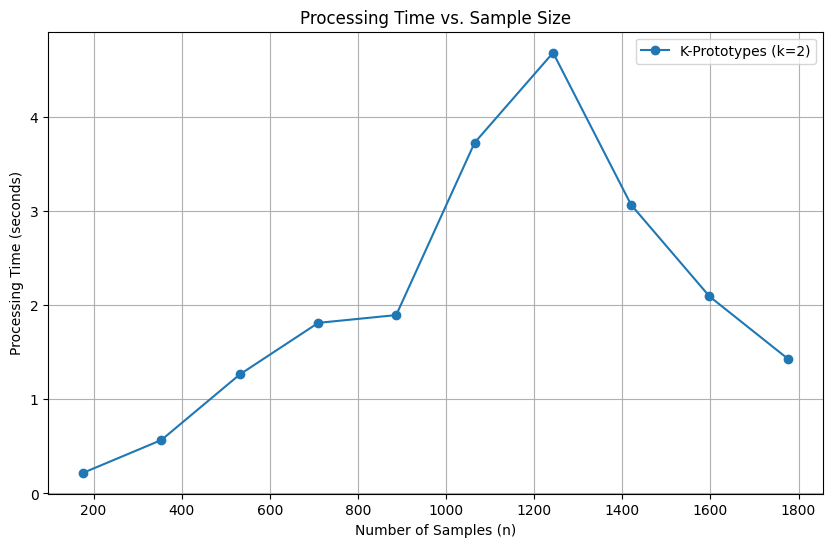

,Number of Samples,Processing Time (s)
0,177,0.220225
1,354,0.567755
2,532,1.264618
3,710,1.812758
4,887,1.895606
5,1065,3.727601
6,1243,4.683707
7,1420,3.068182
8,1598,2.093868
9,1776,1.430756


In [40]:
evaluator.evaluate_processing_time(optimal_k=2, optimal_gamma=2)

**Importância de variáveis e interpretabilidade**


--- Generating Decision Tree Visualization (max_depth=3) 🌳 ---
Found categorical features: ['TP_SEXO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q010', 'Q013', 'Q016', 'Q018', 'Q021', 'Q024']. Applying One-Hot Encoding for the tree...


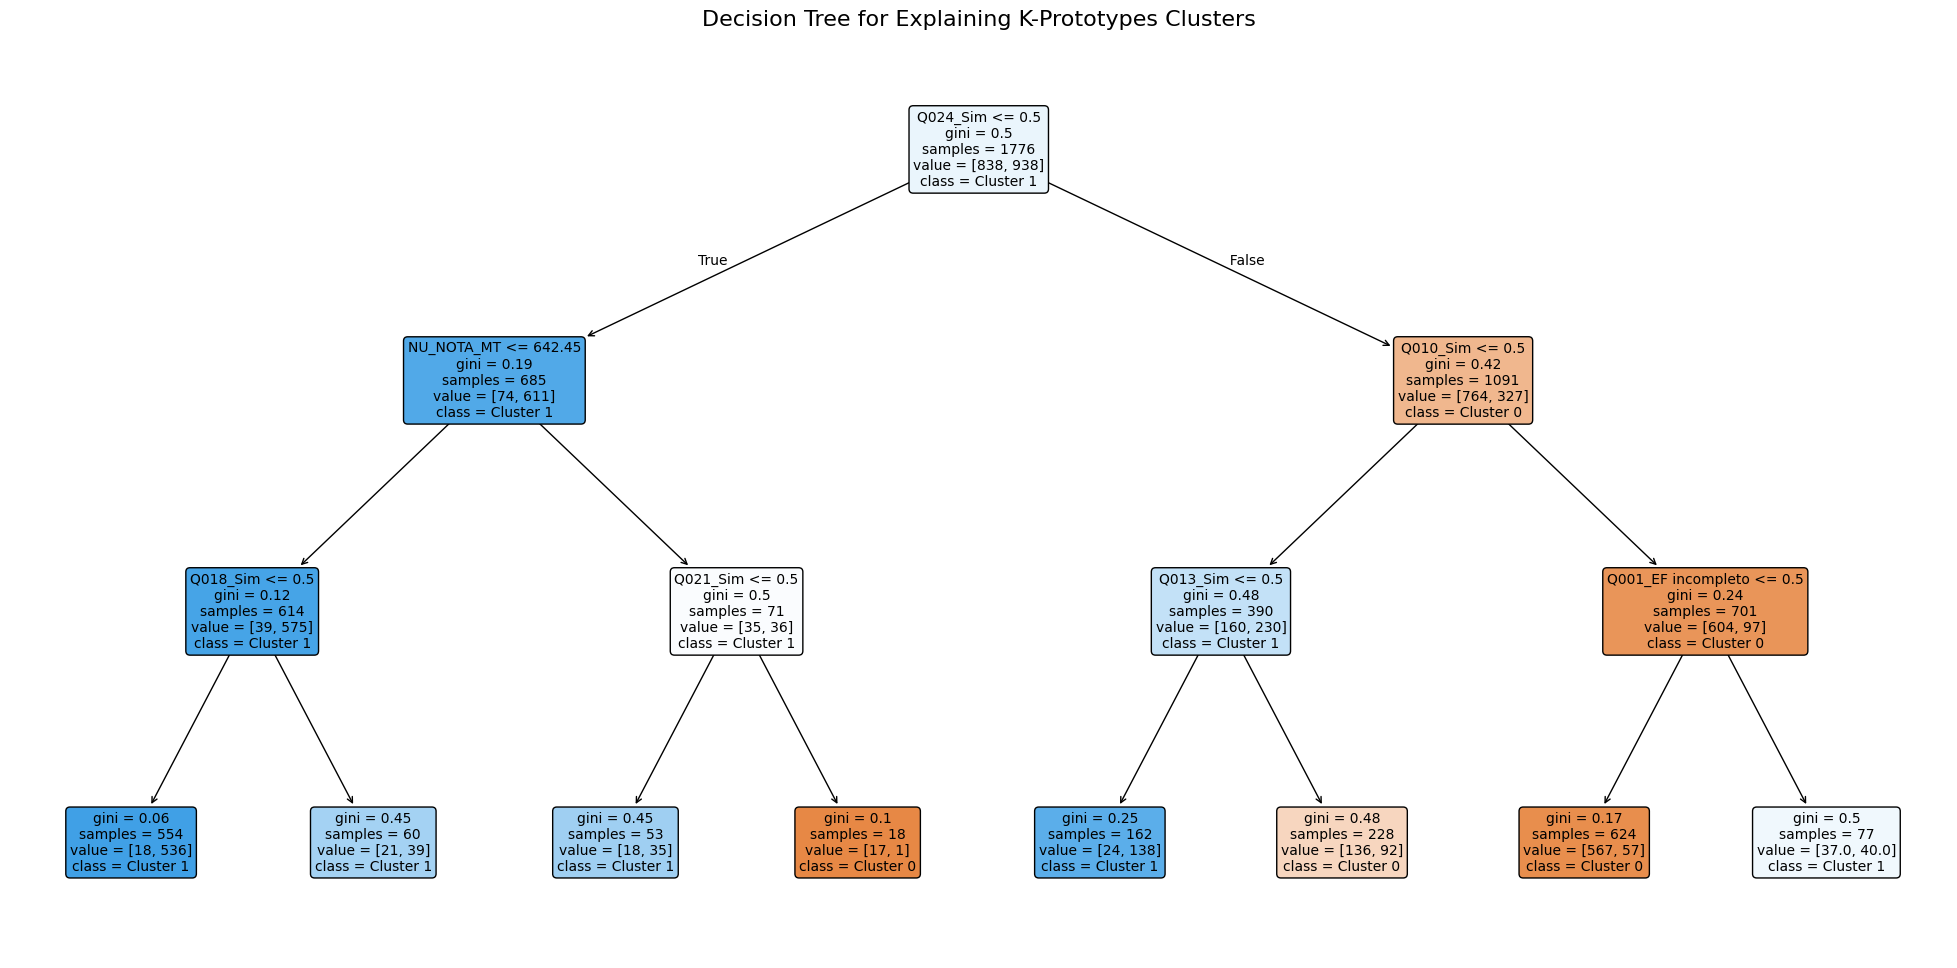

In [41]:
evaluator.plot_decision_tree_importance()


--- Calculating Permutation Importance for K-Prototypes ---
Training Random Forest surrogate model...
Calculating importance based on 'accuracy' drop...


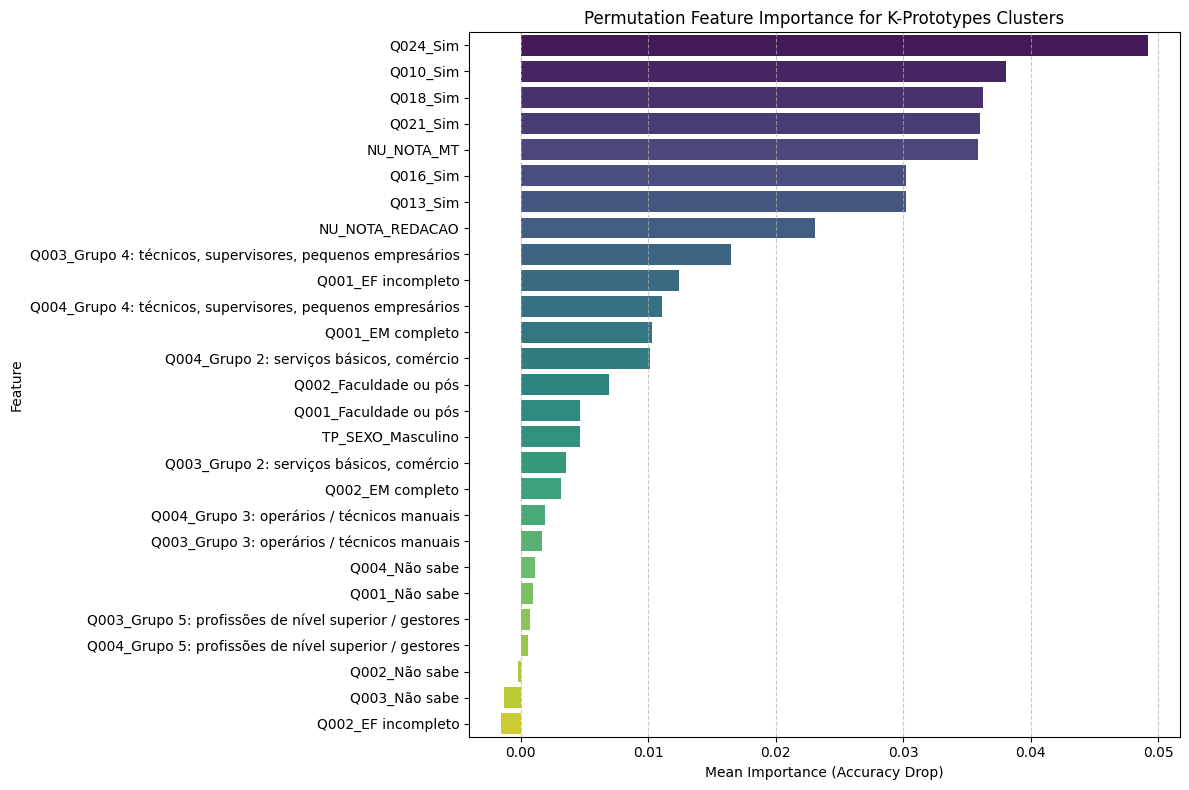

,feature,importance_mean,importance_std
26,Q024_Sim,0.049156,0.010235
21,Q010_Sim,0.038086,0.006502
24,Q018_Sim,0.036210,0.005816
25,Q021_Sim,0.036023,0.003002
0,NU_NOTA_MT,0.035835,0.008197
23,Q016_Sim,0.030206,0.008154
22,Q013_Sim,0.030206,0.005531
1,NU_NOTA_REDACAO,0.023077,0.005107
13,"Q003_Grupo 4: técnicos, supervisores, pequenos...",0.016510,0.004878
3,Q001_EF incompleto,0.012383,0.003677


In [42]:
evaluator.plot_permutation_importance()

In [43]:
anova_results, chi2_results = evaluator.calculate_cluster_statistics()


--- Calculating Cluster Statistics for K-Prototypes ---
Statistical analysis complete.


In [44]:
anova_results

,F-statistic,P-value,Significant
Variable,,,
CO_MUNICIPIO_PROVA,4.471145,3.461105e-02,True
NU_NOTA_CN,354.409950,3.178954e-72,True
NU_NOTA_CH,278.073536,4.136277e-58,True
NU_NOTA_LC,250.458087,7.168595e-53,True
NU_NOTA_MT,669.615116,1.565385e-125,True
NU_NOTA_REDACAO,397.967805,4.761319e-80,True


In [45]:
chi2_results

,Chi-Square,P-value,Significant
Variable,,,
TP_FAIXA_ETARIA,155.528249,6.232169e-24,True
TP_SEXO,24.084818,9.218423e-07,True
TP_COR_RACA,135.423878,1.678901e-27,True
TP_ST_CONCLUSAO,103.918470,2.232532e-22,True
Q001,453.570690,7.343479e-97,True
Q002,503.378010,1.245777e-107,True
Q003,550.020722,1.265528e-116,True
Q004,544.931590,1.589752e-115,True
Q005,35.418980,3.810028e-07,True


In [46]:
cohens_d_results, cramers_v_results = evaluator.calculate_effect_sizes()


--- Calculating Effect Sizes for K-Prototypes ---
Effect size calculation complete.


In [47]:
cohens_d_results

,,Cohen's d
Variable,Comparison,
CO_MUNICIPIO_PROVA,Cluster 0.0 vs 1.0,0.100510
NU_NOTA_CN,Cluster 0.0 vs 1.0,0.894852
NU_NOTA_CH,Cluster 0.0 vs 1.0,0.792643
NU_NOTA_LC,Cluster 0.0 vs 1.0,0.752256
NU_NOTA_MT,Cluster 0.0 vs 1.0,1.230016
NU_NOTA_REDACAO,Cluster 0.0 vs 1.0,0.948248


In [48]:
cramers_v_results

,Cramér's V
Variable,
TP_FAIXA_ETARIA,0.295926
TP_SEXO,0.116453
TP_COR_RACA,0.276138
TP_ST_CONCLUSAO,0.241894
Q001,0.505360
Q002,0.532385
Q003,0.556504
Q004,0.553923
Q005,0.141220
